# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [16]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

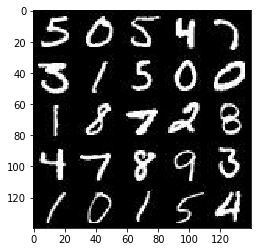

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

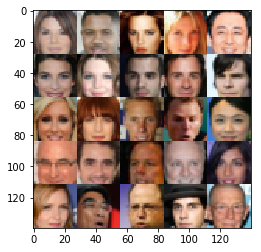

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "input_images")
    z_data = tf.placeholder(tf.float32, (None, z_dim), name = "z_data")
    learning_rate = tf.placeholder(tf.float32)
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train # should it be True or False?
    alpha=0.2    
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        #print("[generator]z.get_shape() = {}".format(z.get_shape()))
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        #print("[generator] x1.shape = {}".format(x1.get_shape()))
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        #print("[generator] x2.shape = {}".format(x2.get_shape()))
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        #print("[generator] x3.shape = {}".format(x3.get_shape()))
        
        #print("[generator] out_channel_dim = {}".format(out_channel_dim))
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x5 now
        #print("[generator] logits.shape = {}".format(logits.get_shape()))
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoothing = 0.9  # factor applied to label smoothing in discriminator loss calculation
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print("[train] started")
    # TODO: Build Model
    
    show_image_every = 500
    show_loss_every = 100
    
    # set up the input placeholders
    input_images, z_data, l_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_images, z_data, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_r, beta1)
    
    with tf.Session() as sess:
        print("[train] executing sess.run(tf.global_variables_initializer())")
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            #print("[train] epoch {}".format(epoch_i))
            batch_num = 0
            for batch_images in get_batches(batch_size):
                #print("[train] batch {}".format(batch_num))
                # TODO: Train Model

                # Get images, reshape and rescale to pass to D
                # reshape to batch size x (w * h)
                #print("[train] data_shape = {}".format(data_shape))
                #batch_images = batch_images.reshape((batch_size, data_shape[1] * data_shape[2]))
                # rescale from (-0.5 to 0.5) to (-1 to 1) 
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_images: batch_images, z_data: batch_z, l_r: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_images: batch_images, z_data: batch_z, l_r: learning_rate})
                # try training generator twice for each discriminator???
                #_ = sess.run(g_train_opt, feed_dict={input_images: batch_images, z_data: batch_z, l_r: learning_rate})
                
                # show output occasionally
                if (batch_num % show_image_every) == 0:
                    show_generator_output(sess, n_images = 25, input_z = z_data, out_channel_dim = data_shape[3], image_mode = data_image_mode)
        
                # show loss occasionally
                if (batch_num % show_loss_every) == 0:
                    # get the losses and print them out
                    train_loss_d = d_loss.eval({input_images: batch_images, z_data: batch_z, l_r: learning_rate})
                    train_loss_g = g_loss.eval({input_images: batch_images, z_data: batch_z, l_r: learning_rate})

                    print("Epoch {}/{} Batch {}...".format(epoch_i + 1, epoch_count, batch_num),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    
                batch_num += 1
                
#        # Save losses to view after training
#        losses.append((train_loss_d, train_loss_g))
#        
#        # Sample from generator as we're training for viewing afterwards
#        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
#        gen_samples = sess.run(
#                       generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),
#                       feed_dict={input_z: sample_z})
#        samples.append(gen_samples)
#        saver.save(sess, './checkpoints/generator.ckpt')
#
## Save training generator samples
#with open('train_samples.pkl', 'wb') as f:
#    pkl.dump(samples, f)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

[train] started
[train] executing sess.run(tf.global_variables_initializer())


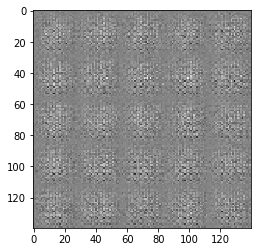

Epoch 1/2 Batch 0... Discriminator Loss: 4.8401... Generator Loss: 0.0163
Epoch 1/2 Batch 100... Discriminator Loss: 0.8793... Generator Loss: 0.9425
Epoch 1/2 Batch 200... Discriminator Loss: 2.0776... Generator Loss: 0.4016
Epoch 1/2 Batch 300... Discriminator Loss: 0.9812... Generator Loss: 1.4351
Epoch 1/2 Batch 400... Discriminator Loss: 0.9176... Generator Loss: 1.0296


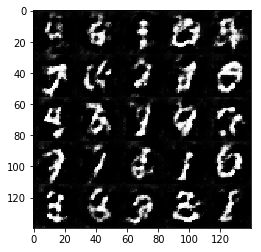

Epoch 1/2 Batch 500... Discriminator Loss: 0.9770... Generator Loss: 2.2717
Epoch 1/2 Batch 600... Discriminator Loss: 1.1309... Generator Loss: 0.7933
Epoch 1/2 Batch 700... Discriminator Loss: 0.9131... Generator Loss: 1.2048
Epoch 1/2 Batch 800... Discriminator Loss: 1.0524... Generator Loss: 0.9726
Epoch 1/2 Batch 900... Discriminator Loss: 1.2375... Generator Loss: 0.6178


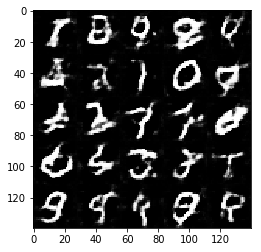

Epoch 1/2 Batch 1000... Discriminator Loss: 1.2177... Generator Loss: 0.6850
Epoch 1/2 Batch 1100... Discriminator Loss: 1.0471... Generator Loss: 0.8215
Epoch 1/2 Batch 1200... Discriminator Loss: 1.0657... Generator Loss: 0.8731
Epoch 1/2 Batch 1300... Discriminator Loss: 0.6300... Generator Loss: 1.7291
Epoch 1/2 Batch 1400... Discriminator Loss: 1.0327... Generator Loss: 1.9756


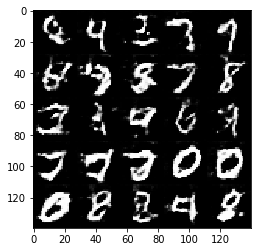

Epoch 1/2 Batch 1500... Discriminator Loss: 0.9057... Generator Loss: 1.6370
Epoch 1/2 Batch 1600... Discriminator Loss: 0.6723... Generator Loss: 1.7064
Epoch 1/2 Batch 1700... Discriminator Loss: 1.4327... Generator Loss: 0.4978
Epoch 1/2 Batch 1800... Discriminator Loss: 0.8355... Generator Loss: 1.0935


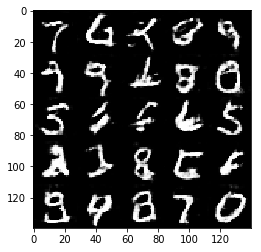

Epoch 2/2 Batch 0... Discriminator Loss: 0.7462... Generator Loss: 1.2249
Epoch 2/2 Batch 100... Discriminator Loss: 0.8814... Generator Loss: 1.0193
Epoch 2/2 Batch 200... Discriminator Loss: 0.6959... Generator Loss: 1.5826
Epoch 2/2 Batch 300... Discriminator Loss: 0.7269... Generator Loss: 1.2464
Epoch 2/2 Batch 400... Discriminator Loss: 0.7967... Generator Loss: 1.2116


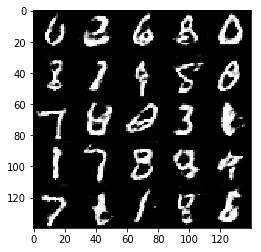

Epoch 2/2 Batch 500... Discriminator Loss: 0.9725... Generator Loss: 0.8937
Epoch 2/2 Batch 600... Discriminator Loss: 0.8663... Generator Loss: 1.0681
Epoch 2/2 Batch 700... Discriminator Loss: 0.6269... Generator Loss: 1.6178
Epoch 2/2 Batch 800... Discriminator Loss: 1.5367... Generator Loss: 0.5332
Epoch 2/2 Batch 900... Discriminator Loss: 0.8187... Generator Loss: 1.1809


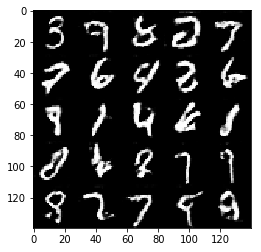

Epoch 2/2 Batch 1000... Discriminator Loss: 0.5892... Generator Loss: 2.0834
Epoch 2/2 Batch 1100... Discriminator Loss: 0.5234... Generator Loss: 1.8511
Epoch 2/2 Batch 1200... Discriminator Loss: 0.6541... Generator Loss: 1.5516
Epoch 2/2 Batch 1300... Discriminator Loss: 0.4771... Generator Loss: 2.2534
Epoch 2/2 Batch 1400... Discriminator Loss: 0.7223... Generator Loss: 1.3569


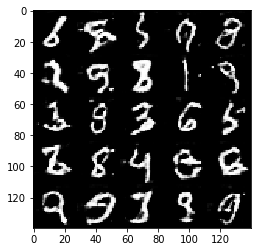

Epoch 2/2 Batch 1500... Discriminator Loss: 0.7506... Generator Loss: 1.5397
Epoch 2/2 Batch 1600... Discriminator Loss: 0.6774... Generator Loss: 1.4044
Epoch 2/2 Batch 1700... Discriminator Loss: 1.0850... Generator Loss: 0.8405
Epoch 2/2 Batch 1800... Discriminator Loss: 0.4490... Generator Loss: 2.7589


In [34]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

[train] started
[train] executing sess.run(tf.global_variables_initializer())


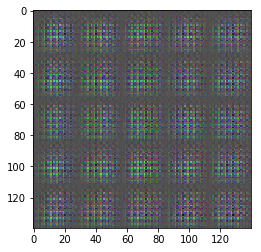

Epoch 1/1 Batch 0... Discriminator Loss: 9.4845... Generator Loss: 0.0002
Epoch 1/1 Batch 100... Discriminator Loss: 1.2355... Generator Loss: 0.9575
Epoch 1/1 Batch 200... Discriminator Loss: 1.6174... Generator Loss: 0.5010
Epoch 1/1 Batch 300... Discriminator Loss: 1.5967... Generator Loss: 1.7292
Epoch 1/1 Batch 400... Discriminator Loss: 1.2562... Generator Loss: 1.0244


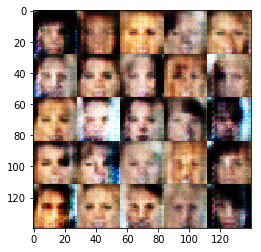

Epoch 1/1 Batch 500... Discriminator Loss: 1.2772... Generator Loss: 0.6446
Epoch 1/1 Batch 600... Discriminator Loss: 0.8344... Generator Loss: 1.0020
Epoch 1/1 Batch 700... Discriminator Loss: 0.8827... Generator Loss: 0.9342
Epoch 1/1 Batch 800... Discriminator Loss: 1.3663... Generator Loss: 0.5050
Epoch 1/1 Batch 900... Discriminator Loss: 1.3263... Generator Loss: 0.5583


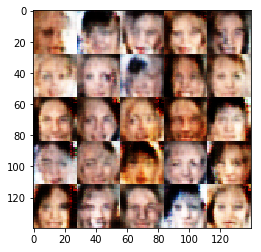

Epoch 1/1 Batch 1000... Discriminator Loss: 1.0110... Generator Loss: 1.2948
Epoch 1/1 Batch 1100... Discriminator Loss: 1.2193... Generator Loss: 0.5948
Epoch 1/1 Batch 1200... Discriminator Loss: 1.0211... Generator Loss: 0.7922
Epoch 1/1 Batch 1300... Discriminator Loss: 0.9561... Generator Loss: 1.0764
Epoch 1/1 Batch 1400... Discriminator Loss: 0.9229... Generator Loss: 2.4941


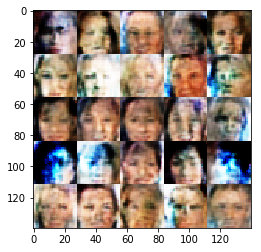

Epoch 1/1 Batch 1500... Discriminator Loss: 0.8467... Generator Loss: 0.9565
Epoch 1/1 Batch 1600... Discriminator Loss: 1.0427... Generator Loss: 1.1251
Epoch 1/1 Batch 1700... Discriminator Loss: 0.6989... Generator Loss: 3.2052
Epoch 1/1 Batch 1800... Discriminator Loss: 1.6960... Generator Loss: 2.1132
Epoch 1/1 Batch 1900... Discriminator Loss: 0.9570... Generator Loss: 0.8732


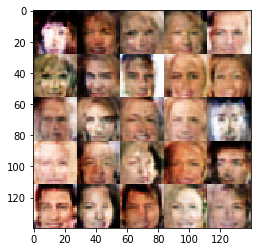

Epoch 1/1 Batch 2000... Discriminator Loss: 0.9540... Generator Loss: 1.7614
Epoch 1/1 Batch 2100... Discriminator Loss: 1.2131... Generator Loss: 2.0010
Epoch 1/1 Batch 2200... Discriminator Loss: 1.0523... Generator Loss: 0.7818
Epoch 1/1 Batch 2300... Discriminator Loss: 1.4266... Generator Loss: 1.9802
Epoch 1/1 Batch 2400... Discriminator Loss: 0.6866... Generator Loss: 1.8127


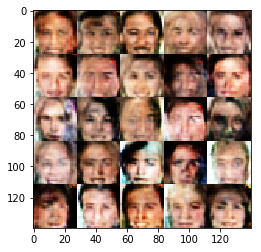

Epoch 1/1 Batch 2500... Discriminator Loss: 1.3027... Generator Loss: 0.5587
Epoch 1/1 Batch 2600... Discriminator Loss: 0.8553... Generator Loss: 1.2478
Epoch 1/1 Batch 2700... Discriminator Loss: 1.0652... Generator Loss: 2.9372
Epoch 1/1 Batch 2800... Discriminator Loss: 0.7186... Generator Loss: 1.2766
Epoch 1/1 Batch 2900... Discriminator Loss: 0.8153... Generator Loss: 1.0492


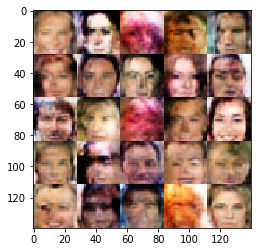

Epoch 1/1 Batch 3000... Discriminator Loss: 1.1033... Generator Loss: 2.7644
Epoch 1/1 Batch 3100... Discriminator Loss: 1.3517... Generator Loss: 0.5964
Epoch 1/1 Batch 3200... Discriminator Loss: 1.0115... Generator Loss: 3.4612
Epoch 1/1 Batch 3300... Discriminator Loss: 0.8952... Generator Loss: 1.1387
Epoch 1/1 Batch 3400... Discriminator Loss: 1.0221... Generator Loss: 0.7923


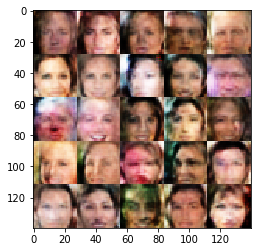

Epoch 1/1 Batch 3500... Discriminator Loss: 0.6991... Generator Loss: 2.0112
Epoch 1/1 Batch 3600... Discriminator Loss: 1.3173... Generator Loss: 0.5287
Epoch 1/1 Batch 3700... Discriminator Loss: 0.6220... Generator Loss: 1.6494
Epoch 1/1 Batch 3800... Discriminator Loss: 0.6988... Generator Loss: 1.3691
Epoch 1/1 Batch 3900... Discriminator Loss: 0.6246... Generator Loss: 1.6707


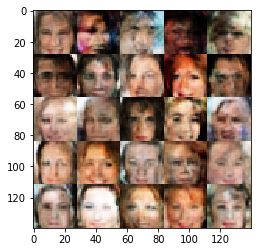

Epoch 1/1 Batch 4000... Discriminator Loss: 2.9013... Generator Loss: 4.1462
Epoch 1/1 Batch 4100... Discriminator Loss: 0.7685... Generator Loss: 1.2140
Epoch 1/1 Batch 4200... Discriminator Loss: 0.6809... Generator Loss: 1.3690
Epoch 1/1 Batch 4300... Discriminator Loss: 0.9708... Generator Loss: 3.3054
Epoch 1/1 Batch 4400... Discriminator Loss: 0.5516... Generator Loss: 1.7671


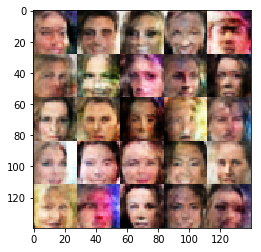

Epoch 1/1 Batch 4500... Discriminator Loss: 0.8530... Generator Loss: 1.4602
Epoch 1/1 Batch 4600... Discriminator Loss: 0.7205... Generator Loss: 1.3089
Epoch 1/1 Batch 4700... Discriminator Loss: 0.8996... Generator Loss: 1.0152
Epoch 1/1 Batch 4800... Discriminator Loss: 0.7429... Generator Loss: 1.2320
Epoch 1/1 Batch 4900... Discriminator Loss: 0.8663... Generator Loss: 3.2983


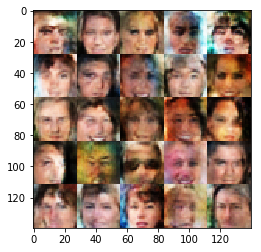

Epoch 1/1 Batch 5000... Discriminator Loss: 0.5059... Generator Loss: 2.1377
Epoch 1/1 Batch 5100... Discriminator Loss: 1.1545... Generator Loss: 0.7158
Epoch 1/1 Batch 5200... Discriminator Loss: 0.7660... Generator Loss: 1.4335
Epoch 1/1 Batch 5300... Discriminator Loss: 0.5040... Generator Loss: 2.0729
Epoch 1/1 Batch 5400... Discriminator Loss: 0.5428... Generator Loss: 2.0365


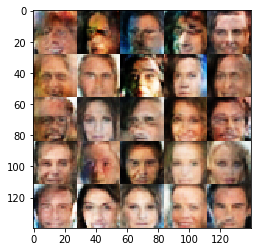

Epoch 1/1 Batch 5500... Discriminator Loss: 0.4986... Generator Loss: 2.1917
Epoch 1/1 Batch 5600... Discriminator Loss: 1.0248... Generator Loss: 0.7997
Epoch 1/1 Batch 5700... Discriminator Loss: 1.7683... Generator Loss: 3.5469
Epoch 1/1 Batch 5800... Discriminator Loss: 1.2886... Generator Loss: 3.0694
Epoch 1/1 Batch 5900... Discriminator Loss: 0.4847... Generator Loss: 2.8987


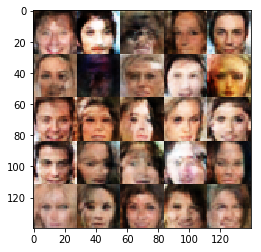

Epoch 1/1 Batch 6000... Discriminator Loss: 0.7597... Generator Loss: 1.2978
Epoch 1/1 Batch 6100... Discriminator Loss: 1.6949... Generator Loss: 0.4322
Epoch 1/1 Batch 6200... Discriminator Loss: 0.4025... Generator Loss: 3.1743
Epoch 1/1 Batch 6300... Discriminator Loss: 1.4148... Generator Loss: 3.3710


In [35]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.